In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


import tensorflow as tf
from sklearn.metrics import *
from sklearn.preprocessing import *
from sklearn.metrics import *
from tensorflow import *
from tensorflow.keras import *
from sklearn.model_selection import *

np.random.seed(111)
tf.random.set_seed(111)



In [2]:
#Wczytywanie danych zestaw Bakterie
df = pd.read_csv("https://raw.githubusercontent.com/paq88/Fish_neural_network_classifier/refs/heads/main/gut_based/Data/gut_full_feature_table.csv")
df.head()

,pond,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelotrichaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Aeromonadales;f__Aeromonadaceae,d__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Yersiniaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;__;__,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae,d__Bacteria;p__Fusobacteriota;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Dysgonomonadaceae,...,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Alteromonadaceae,d__Bacteria;p__Acidobacteriota;c__Vicinamibacteria;o__Vicinamibacterales;f__uncultured,d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Pedosphaerales;f__Pedosphaeraceae,d__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales-Selenomonadales;f__Sporomusaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Alcaligenaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Vibrionales;f__Vibrionaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Flavobacteriales;f__Crocinitomicaceae,d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Arcobacteraceae,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae
0,Gut_S10,2319.0,2187.0,1743.0,500.0,521.0,286.0,366.0,612.0,160.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Gut_S10,3391.0,2071.0,355.0,1054.0,1024.0,1952.0,66.0,217.0,95.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Gut_S10,1338.0,7053.0,669.0,279.0,329.0,63.0,52.0,1338.0,139.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Gut_S10,1582.0,15595.0,124.0,503.0,309.0,5.0,3418.0,326.0,76.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Gut_S10,1463.0,3891.0,541.0,7.0,13.0,11.0,61.0,398.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Wyjaśnienie numerów stawów

| number | setup | pond numbers | water supplementation | feed suplementation |
|---|---|---|---|---|
|0|control | 8,14,18,24,29|NO|NO|
|1|set 1 | 12,16,19,23,26|Em farma|NO|
|2|set 2 | 10,21,28,30,32|Em farma|EM|
|3|set 3 | 9,13,17,20,27|EM|NO|
|4|set 4 | 11,15,22,25,31|EM|EM|

In [3]:
#Sprawdzanie typów danych
df.dtypes.value_counts()

float64    126
object       1
Name: count, dtype: int64

<Axes: >

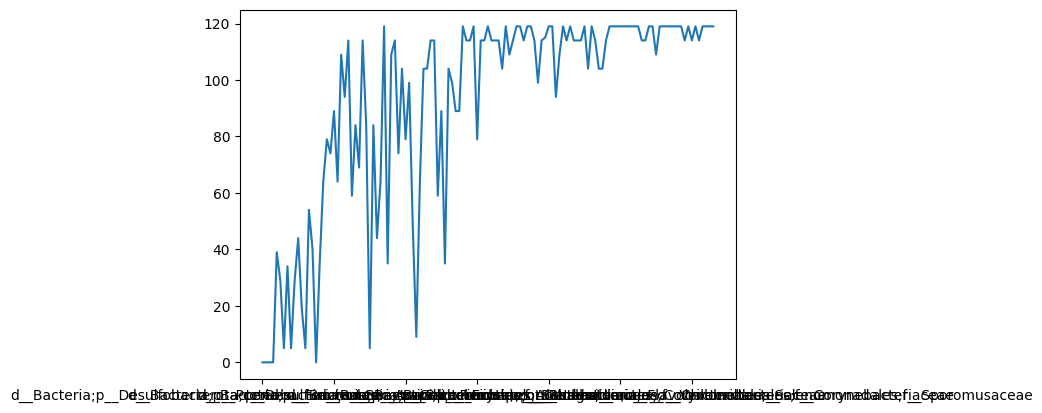

In [4]:
# Brakujące obserwacje
df.isna().sum().plot()


<Axes: >

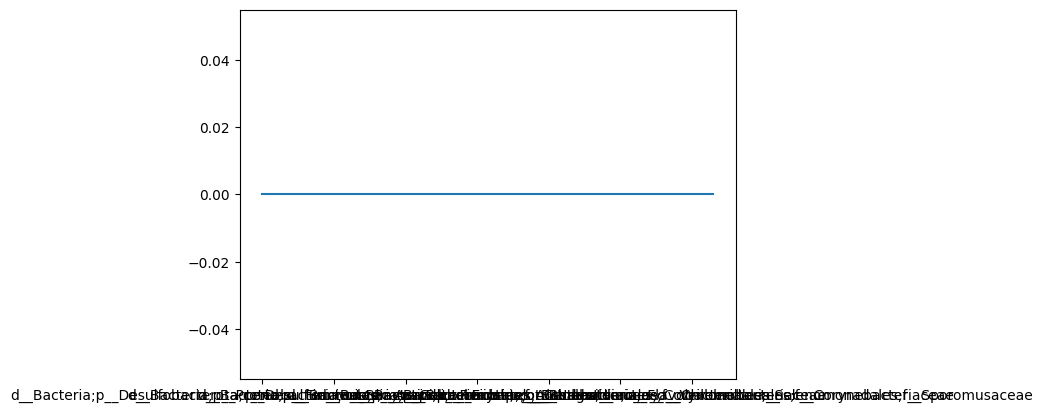

In [5]:
df[df.isnull()] = 0
#df.fillna(0,inplace = True)
#df.replace(np.nan,0)



df.isna().sum().plot()


<Axes: >

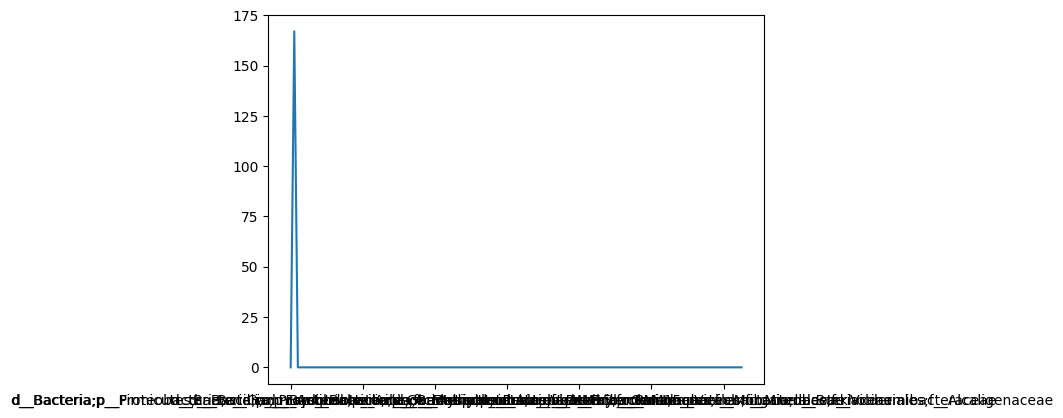

In [6]:
# wartosci min-max dla kolumn
df.iloc[:,1:].min().plot()


<Axes: >

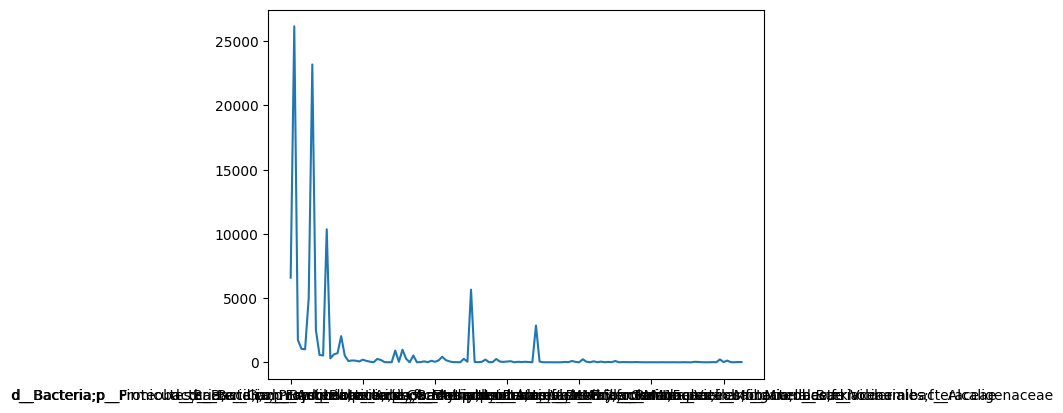

In [7]:
df.iloc[:,1:].max().plot()

In [8]:
# Normalizacja
predyktory = df.columns[1:]
df[predyktory] = df[predyktory]/df[predyktory].max()
df[predyktory] = normalize(df[predyktory],norm = 'max', axis = 0)

In [9]:
codes = {0 : [8,14,18,24,29], 1: [12,16,19,23,26], 2 : [10,21,28,30,32], 3 : [9,13,17,20,27], 4 : [11,15,22,25,31]}

ponds = df['pond'].str.replace('Gut_S','')

klasy = []
for x in ponds:
    x = int(x)
    for key in codes:
        if x in codes[key]:
            klasy.append(key)


df.insert(1,'klasy',klasy)


C:\Users\przem\AppData\Local\Temp\ipykernel_28236\750255890.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.insert(1,'klasy',klasy)


In [10]:
train, test = train_test_split(df, train_size = 0.8,stratify = df['klasy'])

In [11]:
train.shape, test.shape

((99, 128), (25, 128))

In [12]:
train.shape, test.shape
test['klasy'].value_counts()

klasy
3    5
0    5
2    5
1    5
4    5
Name: count, dtype: int64

In [13]:
X_train =  train[predyktory].values
y_train = train['klasy'].values
X_test =  test[predyktory].values
y_test = test['klasy'].values

In [14]:
X_train.shape,X_test.shape

((99, 126), (25, 126))

In [15]:
y_test = keras.utils.to_categorical(y_test,5)
y_train = keras.utils.to_categorical(y_train,5)
X_test.shape,y_test.shape,X_train.shape,y_train.shape

((25, 126), (25, 5), (99, 126), (99, 5))

In [16]:
import xgboost as xgb

In [17]:
dtrain = xgb.DMatrix(X_train, label = train['klasy'])
dtest = xgb.DMatrix(X_test, label = test['klasy'])

parametry = {
    'objective': 'multi:softmax',
    'num_class': 5,
    'max_depth': 3,
    'eta': 0.1,
    'seed': 111
}

x = xgb.train(parametry, dtrain, num_boost_round = 200 )


In [18]:
predykcje = x.predict(dtest)
predykcje

array([3., 2., 3., 1., 3., 4., 0., 1., 3., 0., 4., 3., 4., 0., 4., 4., 3.,
       4., 3., 2., 3., 1., 1., 3., 2.], dtype=float32)

In [19]:
true = test['klasy'].values
true

array([3, 0, 2, 1, 3, 1, 0, 1, 2, 2, 4, 3, 4, 0, 4, 1, 3, 0, 2, 4, 0, 1,
       4, 3, 2], dtype=int64)

In [20]:
accuracy_score(predykcje,true)

0.56

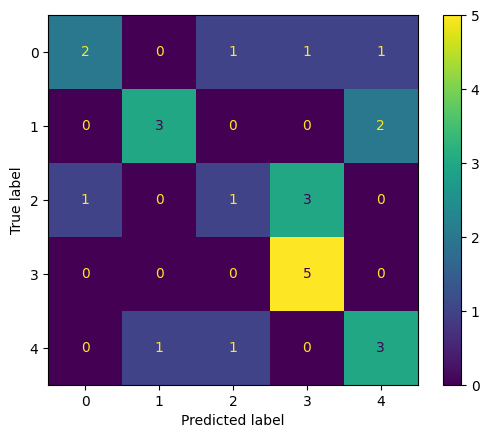

In [21]:
cm = confusion_matrix(true, predykcje)
ConfusionMatrixDisplay(cm).plot()

In [22]:
model1 = keras.Sequential([
    keras.layers.Dense(50, input_shape=(len(predyktory),), activation="relu"),
    keras.layers.Dense(40, activation="relu"),
    keras.layers.Dense(30, activation="sigmoid"),
    keras.layers.Dense(20, activation="sigmoid"),
    keras.layers.Dense(5, activation="softmax")
])

model1.summary()

C:\Users\przem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 50)             │         6,350 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 40)             │         2,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 30)             │         1,230 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 20)             │           620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │           105 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,345 (40.41 KB)

 Trainable params: 10,345 (40.41 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
loss = "categorical_crossentropy"

metryka = ['accuracy']
optimizer = keras.optimizers.Adam(learning_rate = 0.01)
model1.compile(loss = loss, metrics = metryka, optimizer = optimizer)

In [24]:
ES = keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience = 10
)

In [25]:
history1 = model1.fit(X_train, y_train, epochs = 200, shuffle = True, validation_data = [X_test, y_test],callbacks = ES)

Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.1735 - loss: 1.8066 - val_accuracy: 0.2000 - val_loss: 1.6376
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1377 - loss: 1.6200 - val_accuracy: 0.2000 - val_loss: 1.6291
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.1799 - loss: 1.6234 - val_accuracy: 0.2000 - val_loss: 1.6293
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.1799 - loss: 1.6082 - val_accuracy: 0.2000 - val_loss: 1.5971
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3112 - loss: 1.5494 - val_accuracy: 0.3200 - val_loss: 1.5621
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4503 - loss: 1.4850 - val_accuracy: 0.2800 - val_loss: 1.5329
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4873 - loss: 1.4160 - val_accuracy: 0.3200 - val_loss: 1.5049
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5493 - loss: 1.3355 - val_accuracy: 0.3200 - val_loss:

In [ ]:
predykcja_fnn = model1.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


array([[0.00499412, 0.02899185, 0.03727442, 0.8555926 , 0.07314698],
       [0.9444663 , 0.02044494, 0.02552905, 0.00136023, 0.00819952],
       [0.01821104, 0.00550939, 0.9507761 , 0.02099556, 0.00450784],
       [0.00667697, 0.03072572, 0.04849811, 0.8440813 , 0.07001793],
       [0.03285204, 0.19894773, 0.02374206, 0.2835311 , 0.460927  ],
       [0.94181585, 0.02191772, 0.02600548, 0.001386  , 0.00887491],
       [0.08352534, 0.01448997, 0.8330303 , 0.05960656, 0.00934797],
       [0.00413894, 0.02715624, 0.03436736, 0.8640986 , 0.07023881],
       [0.02014557, 0.00565252, 0.950707  , 0.01920548, 0.00428937],
       [0.02171265, 0.04954313, 0.36879808, 0.4478266 , 0.11211956],
       [0.14723003, 0.0321495 , 0.6829338 , 0.11392579, 0.02376086],
       [0.00329218, 0.01987812, 0.05913598, 0.86679184, 0.05090179],
       [0.0179354 , 0.00563936, 0.94904643, 0.02226608, 0.00511277],
       [0.939275  , 0.0230132 , 0.02695654, 0.00147859, 0.00927666],
       [0.01831559, 0.00595943, 0.

In [27]:
predykcje_class = []
for x in predykcja_fnn:
  x = list(x)

  clas = x.index(max(x))
  predykcje_class.append(clas)

predykcje_class

[3, 0, 2, 3, 4, 0, 2, 3, 2, 3, 2, 3, 2, 0, 2, 4, 4, 0, 2, 2, 3, 3, 4, 3, 2]

In [28]:
predykcja_fnn.argmax(axis = 1)

array([3, 0, 2, 3, 4, 0, 2, 3, 2, 3, 2, 3, 2, 0, 2, 4, 4, 0, 2, 2, 3, 3,
       4, 3, 2], dtype=int64)

In [29]:
true_class = y_test.argmax(axis = 1)

In [30]:
accuracy_score(true_class,predykcje_class)

0.44

<Axes: >

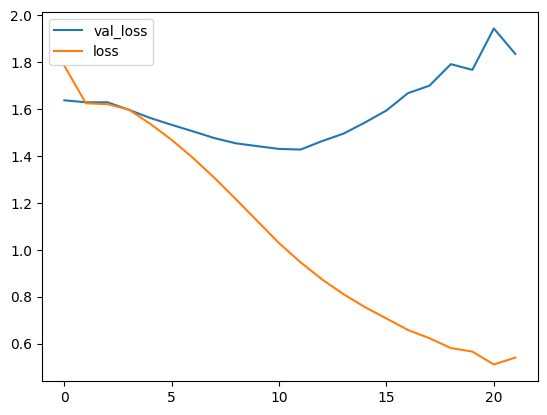

In [31]:
pd.DataFrame({'val_loss':history1.history['val_loss'], 'loss' : history1.history['loss']}).plot()


<Axes: >

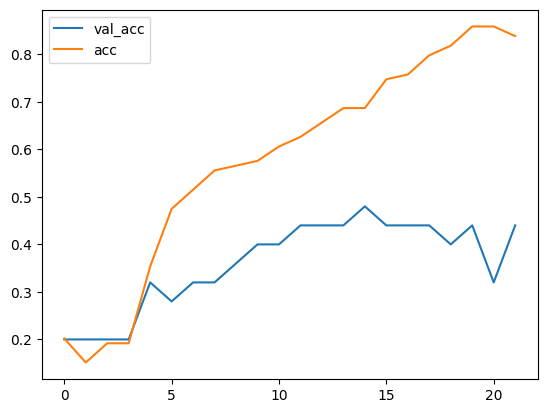

In [32]:
pd.DataFrame({'val_acc':history1.history['val_accuracy'], 'acc' : history1.history['accuracy']}).plot()


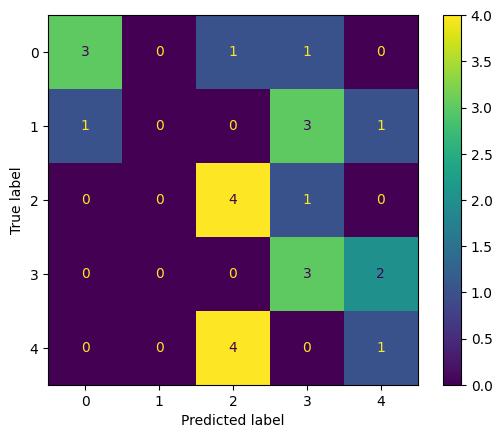

In [33]:
cm = confusion_matrix(true_class, predykcje_class)
ConfusionMatrixDisplay(cm).plot()

In [ ]:
from tpot import TPOTClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

# Load the dataset
data = df
X = df[predyktory]
y = df['klasy']

tpot_config = {
    'xgboost.XGBClassifier': {
        'n_estimators': [10, 50],
        'max_depth': [2, 3, 4],
        'learning_rate': [0.01, 0.1, 0.2],
        'tree_method': ['gpu_hist'],  
        'booster': ['gbtree', 'dart'],
    }
}

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Initialize and train the TPOT model
tpot = TPOTClassifier(verbosity=2, generations=5, population_size=20,n_jobs=-1,scoring='accuracy',config_dict=tpot_config)
tpot.fit(X_train, y_train)

# Evaluate the model
accuracy = tpot.score(X_test, y_test)
print(f"Test Accuracy: {accuracy}")


Optimization Progress:   1%|          | 1/120 [02:50<5:37:51, 170.35s/pipeline]